# ***Multinomial Naive Bayes***

In [1]:
# ============================
# IMPORTS
# ============================
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
import plotly.express as px

from tqdm import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import optuna.visualization as vis
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
import lime
import lime.lime_tabular

import optuna
from optuna.pruners import MedianPruner
from sklearn.preprocessing import LabelEncoder

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# =======================
# LOAD DATA
# =======================
file_path = "../Saber_pro_sampled_data.csv"
df = pd.read_csv(file_path)
#df.head(5000)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': np.int64(0), 'A1': np.int64(1), 'A2': np.int64(2), 'B1': np.int64(3), 'B2': np.int64(4)}


In [4]:
# # ============================
# # PATHS CONFIGURADOS PARA GUARDADO DE OBJETOS
# # ============================
model_filename = "../Models/best_MNB_model.pkl"
metrics_filename = "../Metrics/best_MNB_metrics.pkl"
study_filename = "../Study/optuna_study_MNB.pkl"
fold_metrics_filename = "../Metrics/MNB_folds_summary.csv"

In [5]:

# ============================
# EVALUATION FUNCTION
# ============================
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [6]:
def build_pipeline(params, numeric_features, categorical_features):
    # Preprocessing for numeric and categorical features
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ],
        verbose_feature_names_out=False
    )

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MultinomialNB(**params))
    ])

    return model


In [7]:
# ============================
# FOLD METRIC SAVER
# ============================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    df = pd.DataFrame(folds_metrics)
    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()
    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'
    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    df_final.to_csv(filename, index=False)
    print(f"\n📁 Fold metrics + summary saved to: {filename}")
    return df_final

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [8]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50): 
    def objective(trial):
        params = {"alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True)}
        
        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
        scores = []
        
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            model.fit(X_t, y_t)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [9]:
# ============================
# NESTED CV
# ============================
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [10]:
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [11]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['FAMI_ESTRATOVIVIENDA',...
                                                   'ESTU_VALORMATRICULAUNIVERSIDAD',
                                                   'INST_CARACTER_ACADEMICO',
                                                   'INST_ORIGEN', 'ESTU_GENERO',
                                                   'ESTU_NACIONALIDAD',
                                                   'ESTU_HORASSEMANATRABAJA',
                                                   'ESTU_PAGOMATRICULABECA',
                                                   'ESTU_PAGOMATRICULACREDITO',
                                                   'ESTU_PAGOMATRICULAPADRES',
                                                   'ESTU_PAGOMATRICULAPROPIO',
                                                   'ESTU_DEPTO_RESIDE',
                                                   'ESTU_DEPTO_PRESENTACION'])],
                                   verbose_feature_names_out=False)),
                ('classifier', MultinomialNB(alpha=4.0411962697078465))])

In [32]:
print(metrics['classification_report_train'])

              precision    recall  f1-score   support

           0       0.29      0.20      0.24      6089
           1       0.35      0.29      0.32     13827
           2       0.47      0.51      0.49     25076
           3       0.36      0.34      0.35     14341
           4       0.41      0.55      0.47      6580

    accuracy                           0.40     65913
   macro avg       0.38      0.38      0.37     65913
weighted avg       0.40      0.40      0.40     65913



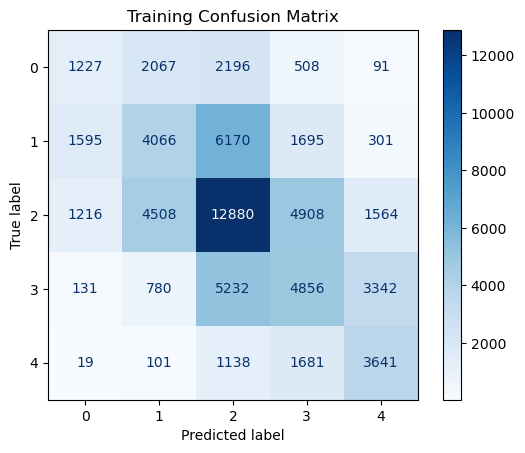

In [33]:
plot_confusion_matrix(metrics['confusion_matrix_train'], metrics['labels'], "Training Confusion Matrix")

In [12]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.30      0.21      0.24      1523
           1       0.35      0.29      0.32      3457
           2       0.46      0.51      0.48      6269
           3       0.34      0.33      0.34      3585
           4       0.41      0.54      0.46      1645

    accuracy                           0.40     16479
   macro avg       0.37      0.38      0.37     16479
weighted avg       0.39      0.40      0.39     16479



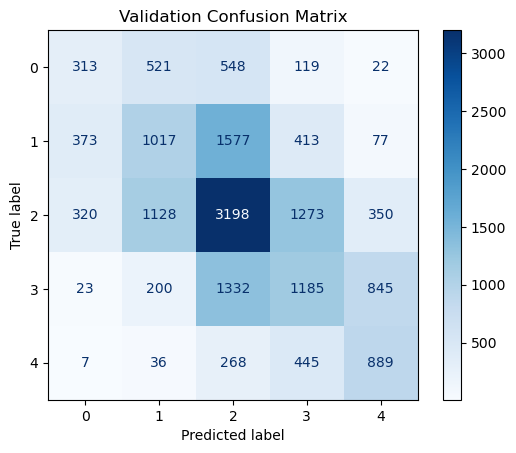

In [13]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [14]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.29      0.20      0.23      1904
           1       0.36      0.29      0.32      4321
           2       0.47      0.52      0.49      7836
           3       0.35      0.35      0.35      4481
           4       0.42      0.55      0.47      2056

    accuracy                           0.41     20598
   macro avg       0.38      0.38      0.37     20598
weighted avg       0.40      0.41      0.40     20598



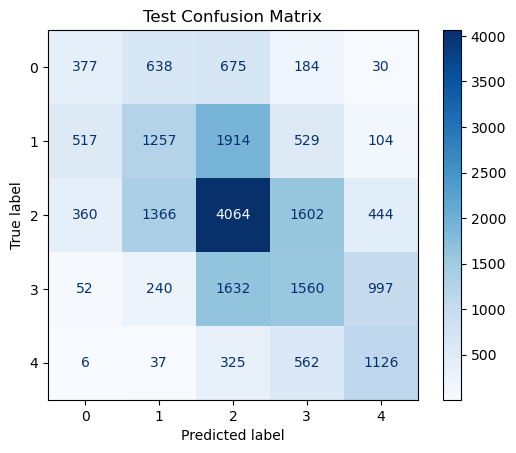

In [15]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

--- Explanation for class 0 ---


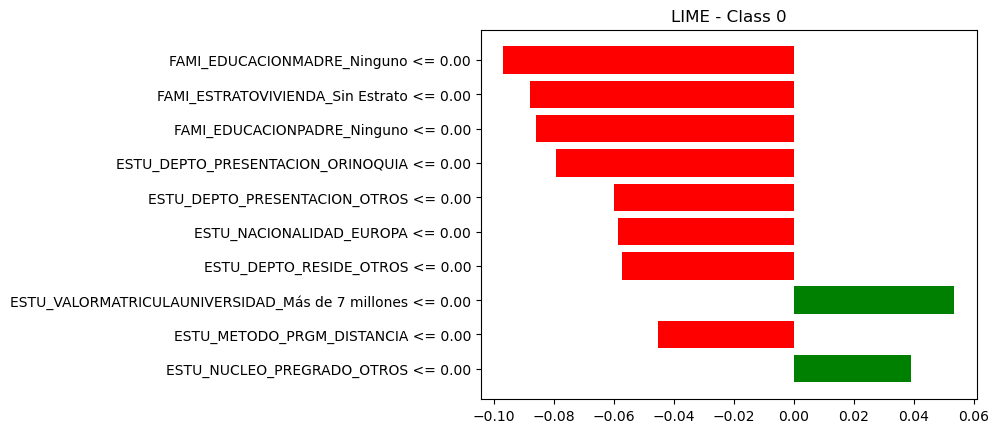

--- Explanation for class 1 ---


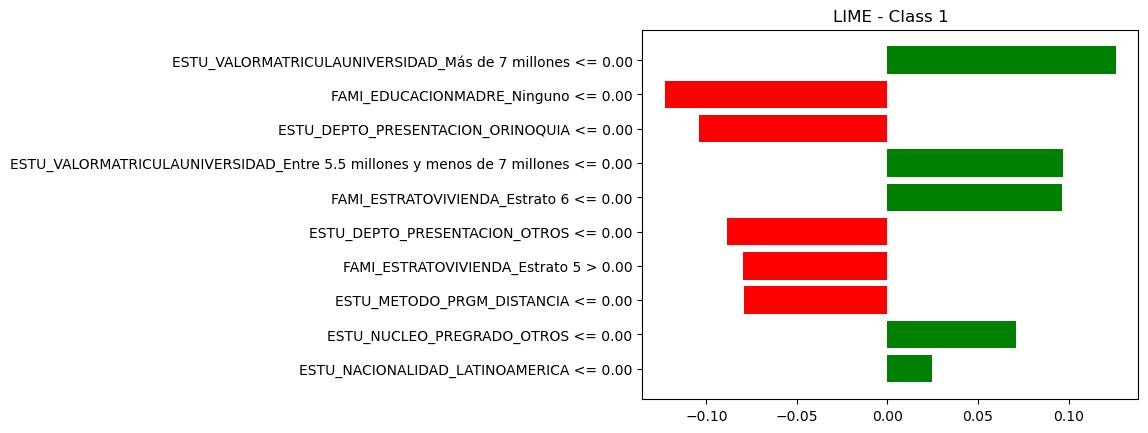

--- Explanation for class 2 ---


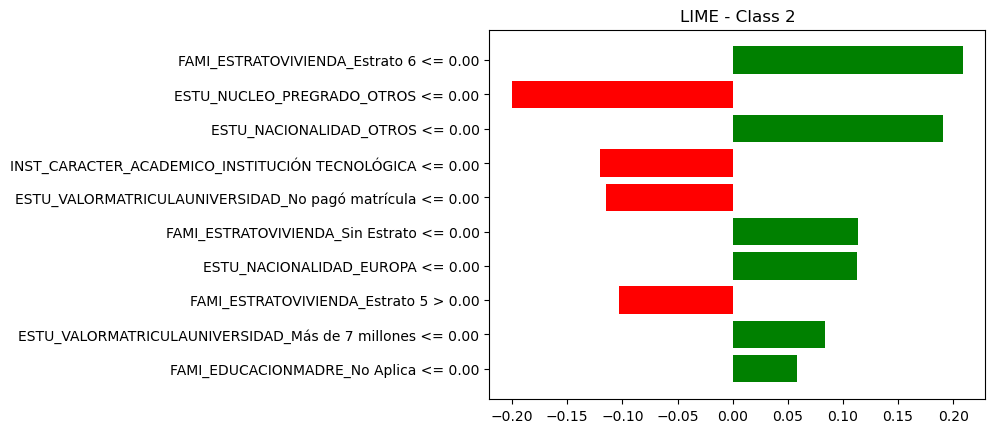

--- Explanation for class 3 ---


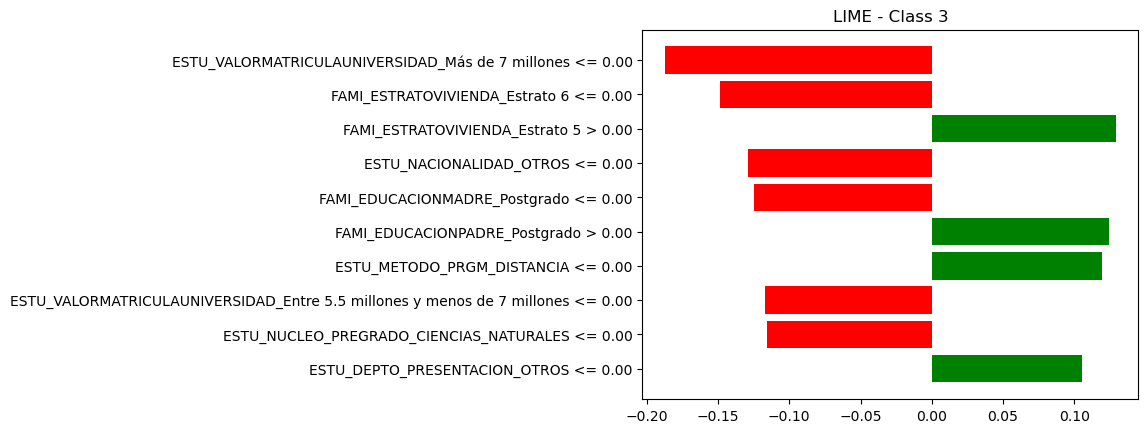

--- Explanation for class 4 ---


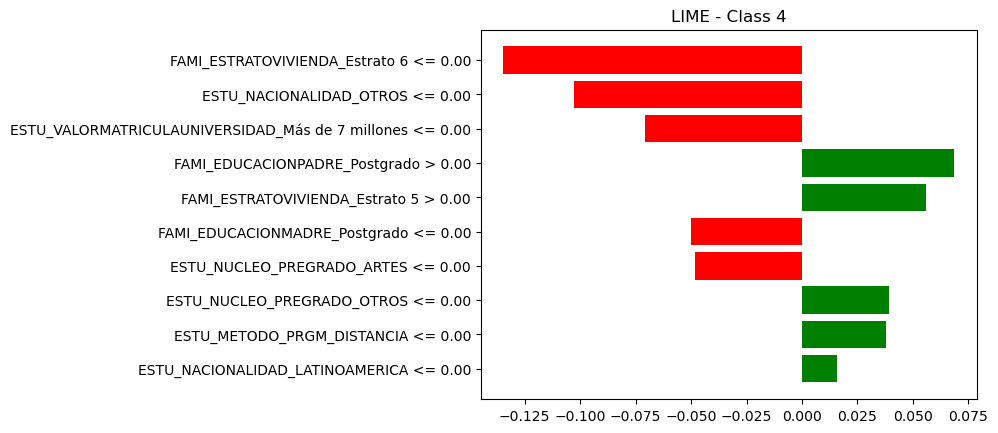

In [16]:
# ============================
# LIME EXPLANATION FOR NB
# ============================

X_transformed = model.named_steps["preprocessor"].transform(metrics['X_train_fold'])

def predict_fn(x):
    return model.named_steps["classifier"].predict_proba(x)

feature_names = model.named_steps["preprocessor"].get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

instance = X_transformed[10]

exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2,3 ,4])

exp.show_in_notebook(show_table=True)

for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [17]:
visualizations['optimization_history']

In [18]:
visualizations['parallel_coordinate']

In [19]:
visualizations['f1_score_evolution']

In [20]:
visualizations['param_importances']

In [21]:
reporte.save(metrics, model_name="Mult_NB")


✅ Report for model 'Mult_NB' saved:
   → CSV: ../Metrics/Metrics_Mult_NB.csv
   → JSON: ../Metrics/Metrics_Mult_NB.json


In [22]:
df = reporte.load()


✅ Loaded 7 report(s):
   → Models: ['NB_Partial', 'RF', 'Mult_NB', 'CART_SMOTE', 'Bern_NB', 'CART_ADASYN', 'CART']
   → Types : ['train', 'val', 'test']


In [23]:
df.query("Model == 'Mult_NB' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
48,Mult_NB,train,0,0.293,0.202,0.239
49,Mult_NB,train,1,0.353,0.294,0.321
50,Mult_NB,train,2,0.466,0.514,0.489
51,Mult_NB,train,3,0.356,0.339,0.347
52,Mult_NB,train,4,0.407,0.553,0.469
53,Mult_NB,train,macro avg,0.375,0.38,0.373
54,Mult_NB,train,weighted avg,0.397,0.405,0.398


In [24]:
df.query("Model == 'Mult_NB' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
56,Mult_NB,val,0,0.302,0.206,0.245
57,Mult_NB,val,1,0.35,0.294,0.32
58,Mult_NB,val,2,0.462,0.51,0.485
59,Mult_NB,val,3,0.345,0.331,0.338
60,Mult_NB,val,4,0.407,0.54,0.464
61,Mult_NB,val,macro avg,0.373,0.376,0.37
62,Mult_NB,val,weighted avg,0.393,0.401,0.394


In [25]:
df.query("Model == 'Mult_NB' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
64,Mult_NB,test,0,0.287,0.198,0.234
65,Mult_NB,test,1,0.355,0.291,0.32
66,Mult_NB,test,2,0.472,0.519,0.494
67,Mult_NB,test,3,0.352,0.348,0.35
68,Mult_NB,test,4,0.417,0.548,0.473
69,Mult_NB,test,macro avg,0.377,0.381,0.374
70,Mult_NB,test,weighted avg,0.399,0.407,0.4


In [26]:
df.query("Model == 'Mult_NB' and auc != '-'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
55,Mult_NB,train,0.405,1.545,0.689
63,Mult_NB,val,0.401,1.55,0.687
71,Mult_NB,test,0.407,1.547,0.69


In [27]:
df.query("Model == 'Mult_NB' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
63,Mult_NB,val,0.401,1.55,0.687


In [28]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


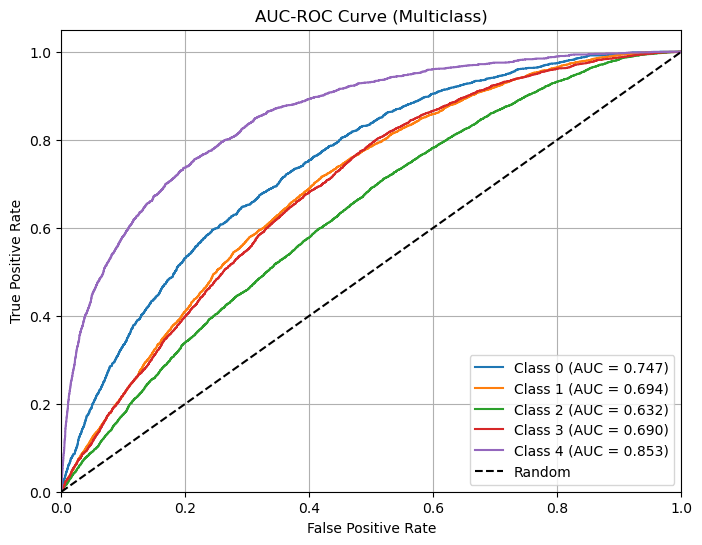

In [29]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [30]:
model.named_steps['classifier'].get_params()

{'alpha': 4.0411962697078465,
 'class_prior': None,
 'fit_prior': True,
 'force_alpha': True}

In [31]:
df = pd.read_csv(fold_metrics_filename)
df

,fold,f1_train,accuracy_train,log_loss_train,auc_train,f1_val,accuracy_val,log_loss_val,auc_val,f1_test,accuracy_test,log_loss_test,auc_test,optuna_time
0,1,0.398,0.405,1.542,0.689,0.401,0.408,1.531,0.692,0.396,0.403,1.548,0.688,81.332
1,2,0.397,0.404,1.540,0.689,0.402,0.410,1.531,0.692,0.396,0.402,1.539,0.688,78.718
2,3,0.398,0.405,1.541,0.689,0.400,0.407,1.541,0.690,0.394,0.401,1.550,0.687,79.038
3,4,0.398,0.405,1.545,0.689,0.393,0.400,1.560,0.686,0.396,0.403,1.545,0.687,78.959
4,5,0.398,0.405,1.545,0.689,0.394,0.401,1.550,0.687,0.400,0.407,1.547,0.690,78.725
5,mean,0.398,0.405,1.542,0.689,0.398,0.405,1.543,0.689,0.396,0.403,1.546,0.688,79.354
6,std,0.000,0.000,0.003,0.000,0.004,0.005,0.013,0.003,0.002,0.002,0.004,0.001,1.115
